# Credit Score Model- Kaggle Public Dataset

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from scipy import stats
from collections import Counter
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from scipy.stats import zscore

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import ExtraTreeClassifier

from sklearn.metrics import accuracy_score, classification_report

import lightgbm as lgb

from boruta import BorutaPy
import xgboost as xgb

%matplotlib inline
%pylab inline
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24
display( HTML( '<style>.container { width:100% !important; }</style>') )
pd.options.display.max_columns = None
pd.options.display.max_rows = 100
pd.set_option( 'display.expand_frame_repr', False )
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Features

'ID' - Chave única de identificação da entrada

'Customer_ID' - Chave única de identificação da pessoa

'Month' - Mês de referência

'Name' - Nome do cliente

'Age' - Idade

'SSN' - Documento de identificação

'Occupation' - Profissão

'Annual_Income' - Renda Anual

'Monthly_Inhand_Salary' - Salario Base Mensal

'Num_Bank_Accounts' - Número de Contas Bancárias

'Num_Credit_Card' - Número de Cartões de Crédito

'Interest_Rate' - Taxa de Juros

'Num_of_Loan' - Número de Emprestimos

'Type_of_Loan' - Tipo de Emprestimos

'Delay_from_due_date' - Dias médios de atraso da data de vencimento

'Num_of_Delayed_Payment' - Número de atrasos

'Changed_Credit_Limit' - Percentual de mudança no limite do cartão de crédito

'Num_Credit_Inquiries' - Números de consultas em Bureau

'Credit_Mix' - Classificação do nivel de diversidade de credito

'Outstanding_Debt' - Divída em aberto

'Credit_Utilization_Ratio' - Total utilizado em relação ao limite

'Credit_History_Age' - Tempo de crédito no mercado

'Payment_of_Min_Amount' - Representa se foi feito pagamento mínimo

'Total_EMI_per_month' - Parcela fixa mensal (principal + juros)

'Amount_invested_monthly' - Total investido no mês

'Payment_Behaviour' - Comportamento de Pagamento do cliente

'Monthly_Balance' - Saldo Mensal

'Credit_Score' - Score de Crédito

# Auxiliary Functions

In [2]:
# Function to unnest the list 
def desaninhar(nested_list):
    result = []
    for element in nested_list:
        if isinstance(element, list):
            result.extend(desaninhar(element))
        else:
            result.append(element)
    return result


# Function to calculate the mode of items in a list by removing the empty ones
def calcular_moda(row_list):
    
    new_list = [item for item in row_list if item != '']
    counter = Counter(new_list)
    return counter.most_common(1)[0][0]

## Kramer's V method for correlation of categorical variables
def cramer_v (x,y):

    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0 , chi2 - ((k-1)*(r-1)/(n-1))) # bias-corrected values


    kcorr =  k - ((k-1)**2/(n-1))  # bias-corrected values
    rcorr =  r - ((r-1)**2/(n-1))  # bias-corrected values
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

# Exploratory Data Analysis (EDA)

The objective is to analyze the data with the aim of identifying and rectifying any potential errors in each column while achieving a deeper understanding of each variable.

In [3]:
# data reading
data = pd.read_csv('train.csv', low_memory=False)

## Initial Features Treatment 

We went through feature by feature to understand them and apply what makes sense in terms of score analysis. For the vast majority of variables, we followed the step-by-step process of observing, correcting, and sometimes establishing a relationship with a potential response variable.

In [4]:
# all columns of dataset
data.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [5]:
df1 = data.copy()

In [6]:
# Checking variables type
df1.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                

### Type_of_Loan

In [7]:
result = []

# Creating a list with all entries from the 'Type_of_Loan' column
text_list = list(df1['Type_of_Loan'].astype(str))

# Separating loan types within the list
for loan in text_list:
    text = re.split(r',|and', loan)
    result.append(text)

# Creating a list with unique loan types
loan_types = desaninhar(result)
loan_types = list(set(loan_types))

# Processing the created list
new_list = []
for type in loan_types:
    initial_text = re.sub(r'\s+|nan|','',type)
    new_list.append(initial_text)

# Removing empty values from the list
empty_list = [item for item in new_list if item != '']
loan_types = list(set(empty_list))


df1['Type_of_Loan'] = df1['Type_of_Loan'].astype(str).apply(lambda x: re.sub(r'\s+','',x))

# Creating a column for each loan type
for i in loan_types:
    df1[('loan_type_')+i] = np.nan
    df1[('loan_type_')+i] = df1['Type_of_Loan'].apply(lambda x: 1 if re.search(i,x) else 0)

 
df1.drop('Type_of_Loan',axis=1,inplace=True)

### Occupation

In [58]:
df1['Occupation'].value_counts(dropna=False)

_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: Occupation, dtype: int64

Analyzing the 'occupation' column, we can observe a wide range of professions. 
To correct the errors, we used 'replace' and mode function.

In [59]:
df1['Occupation'] = df1['Occupation'].replace('_______','')
df1['Occupation'] = df1.groupby('Customer_ID')['Occupation'].transform(calcular_moda)
df1['Occupation'].value_counts(dropna=False)

Lawyer           7096
Engineer         6864
Architect        6824
Mechanic         6776
Scientist        6744
Accountant       6744
Developer        6720
Media_Manager    6720
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
Name: Occupation, dtype: int64

### Annual_Income

In [60]:
df1['Annual_Income'] = df1['Annual_Income'].apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Annual_Income'] = df1['Annual_Income'].astype(np.float64)

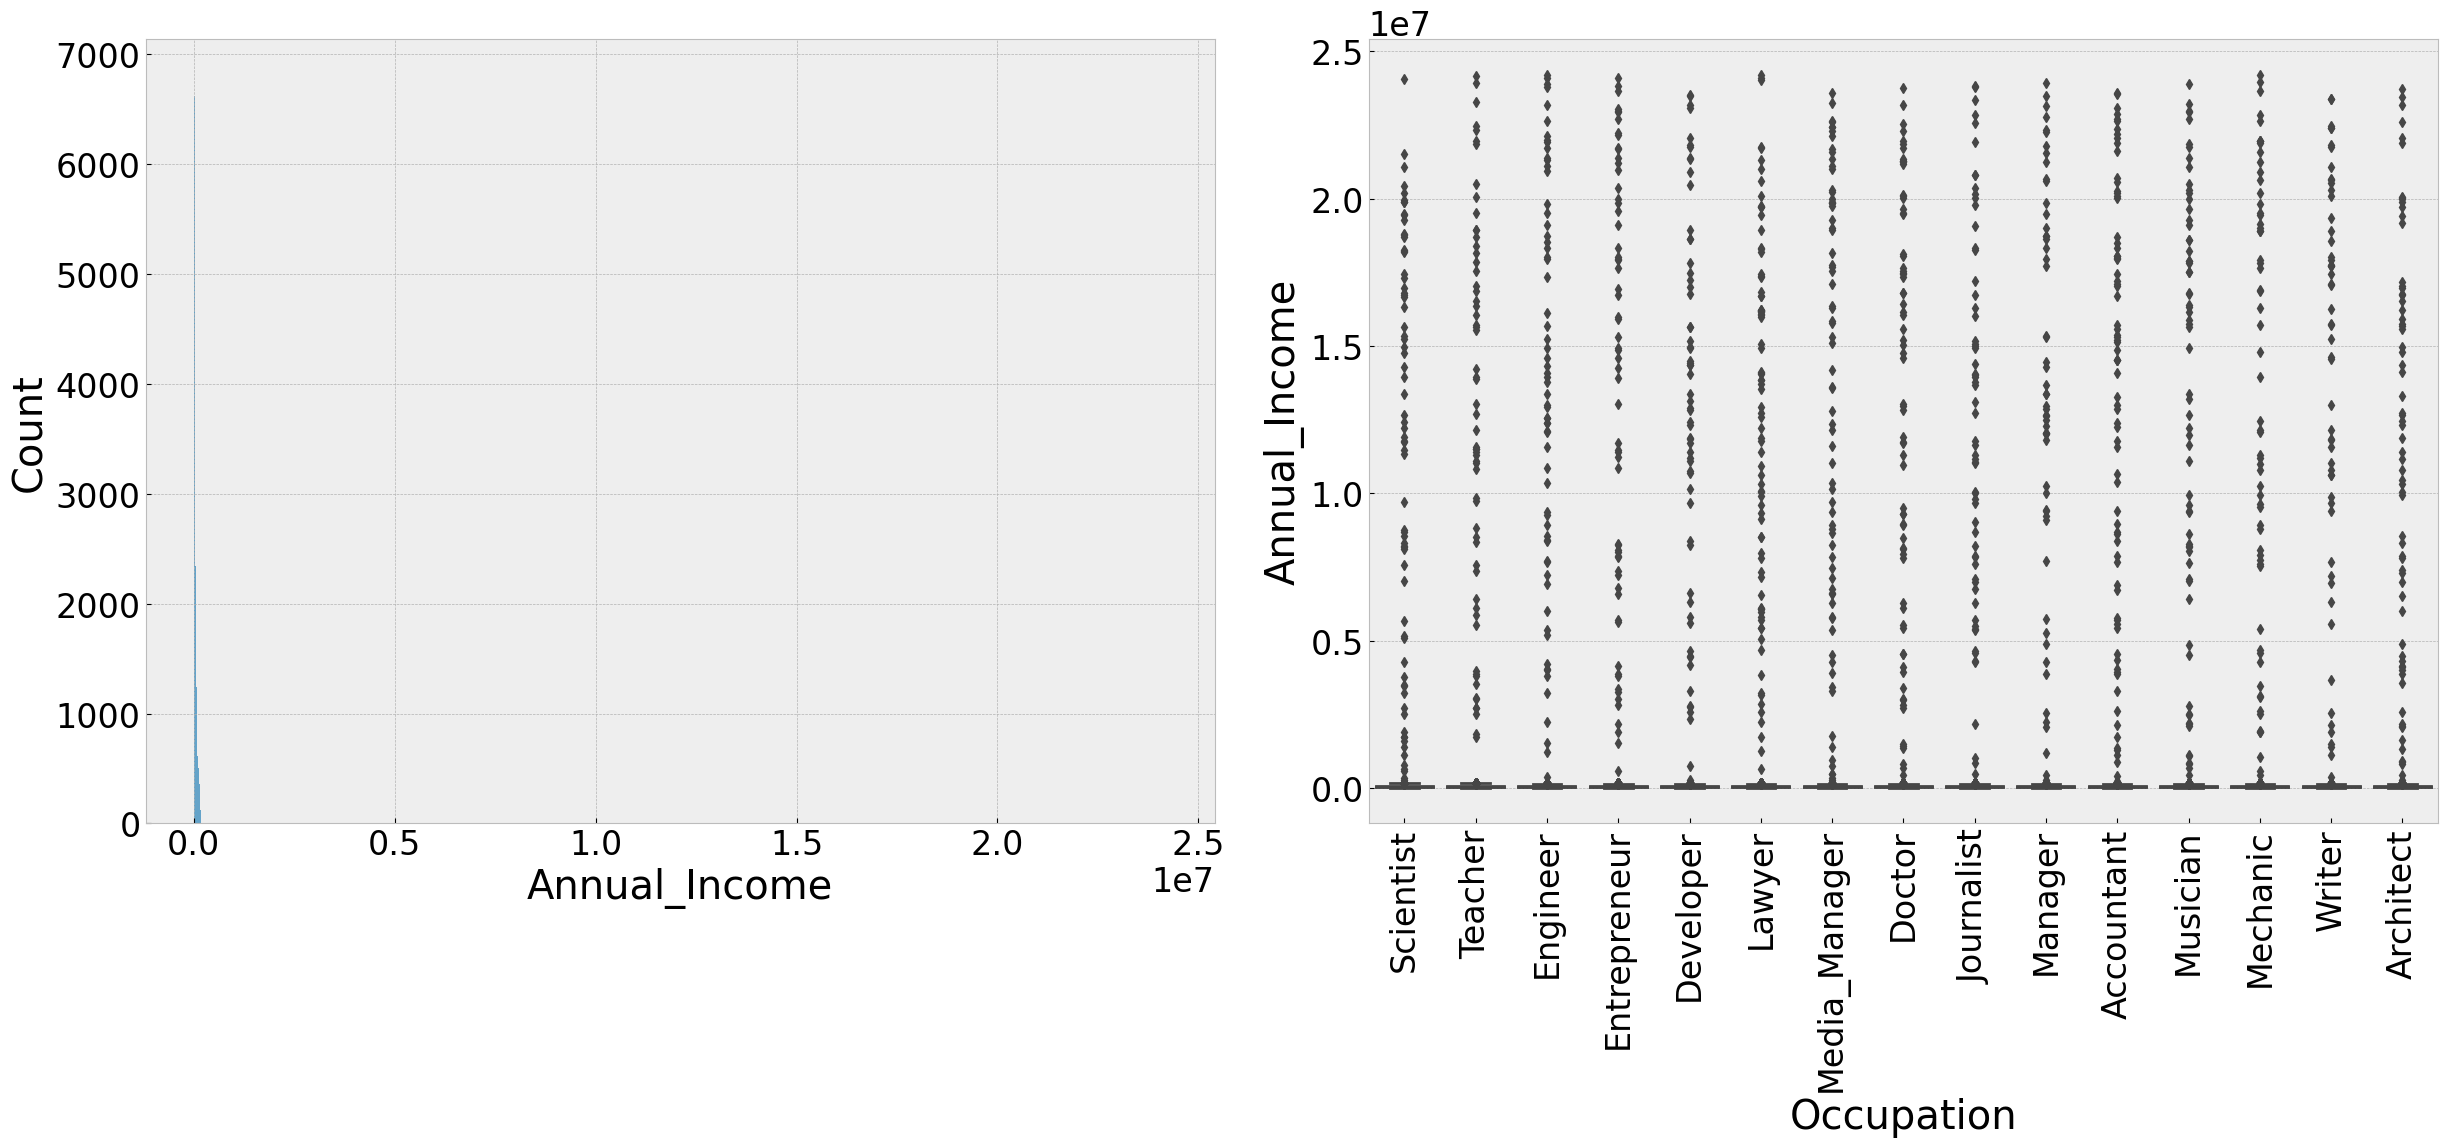

In [61]:
plt.subplot(1,2,1)
sns.histplot(df1['Annual_Income'])

plt.subplot(1,2,2)
sns.boxplot(data = df1 , x='Occupation',y='Annual_Income')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [62]:
df1['Annual_Income'] = df1.groupby('Customer_ID')['Annual_Income'].transform(calcular_moda)

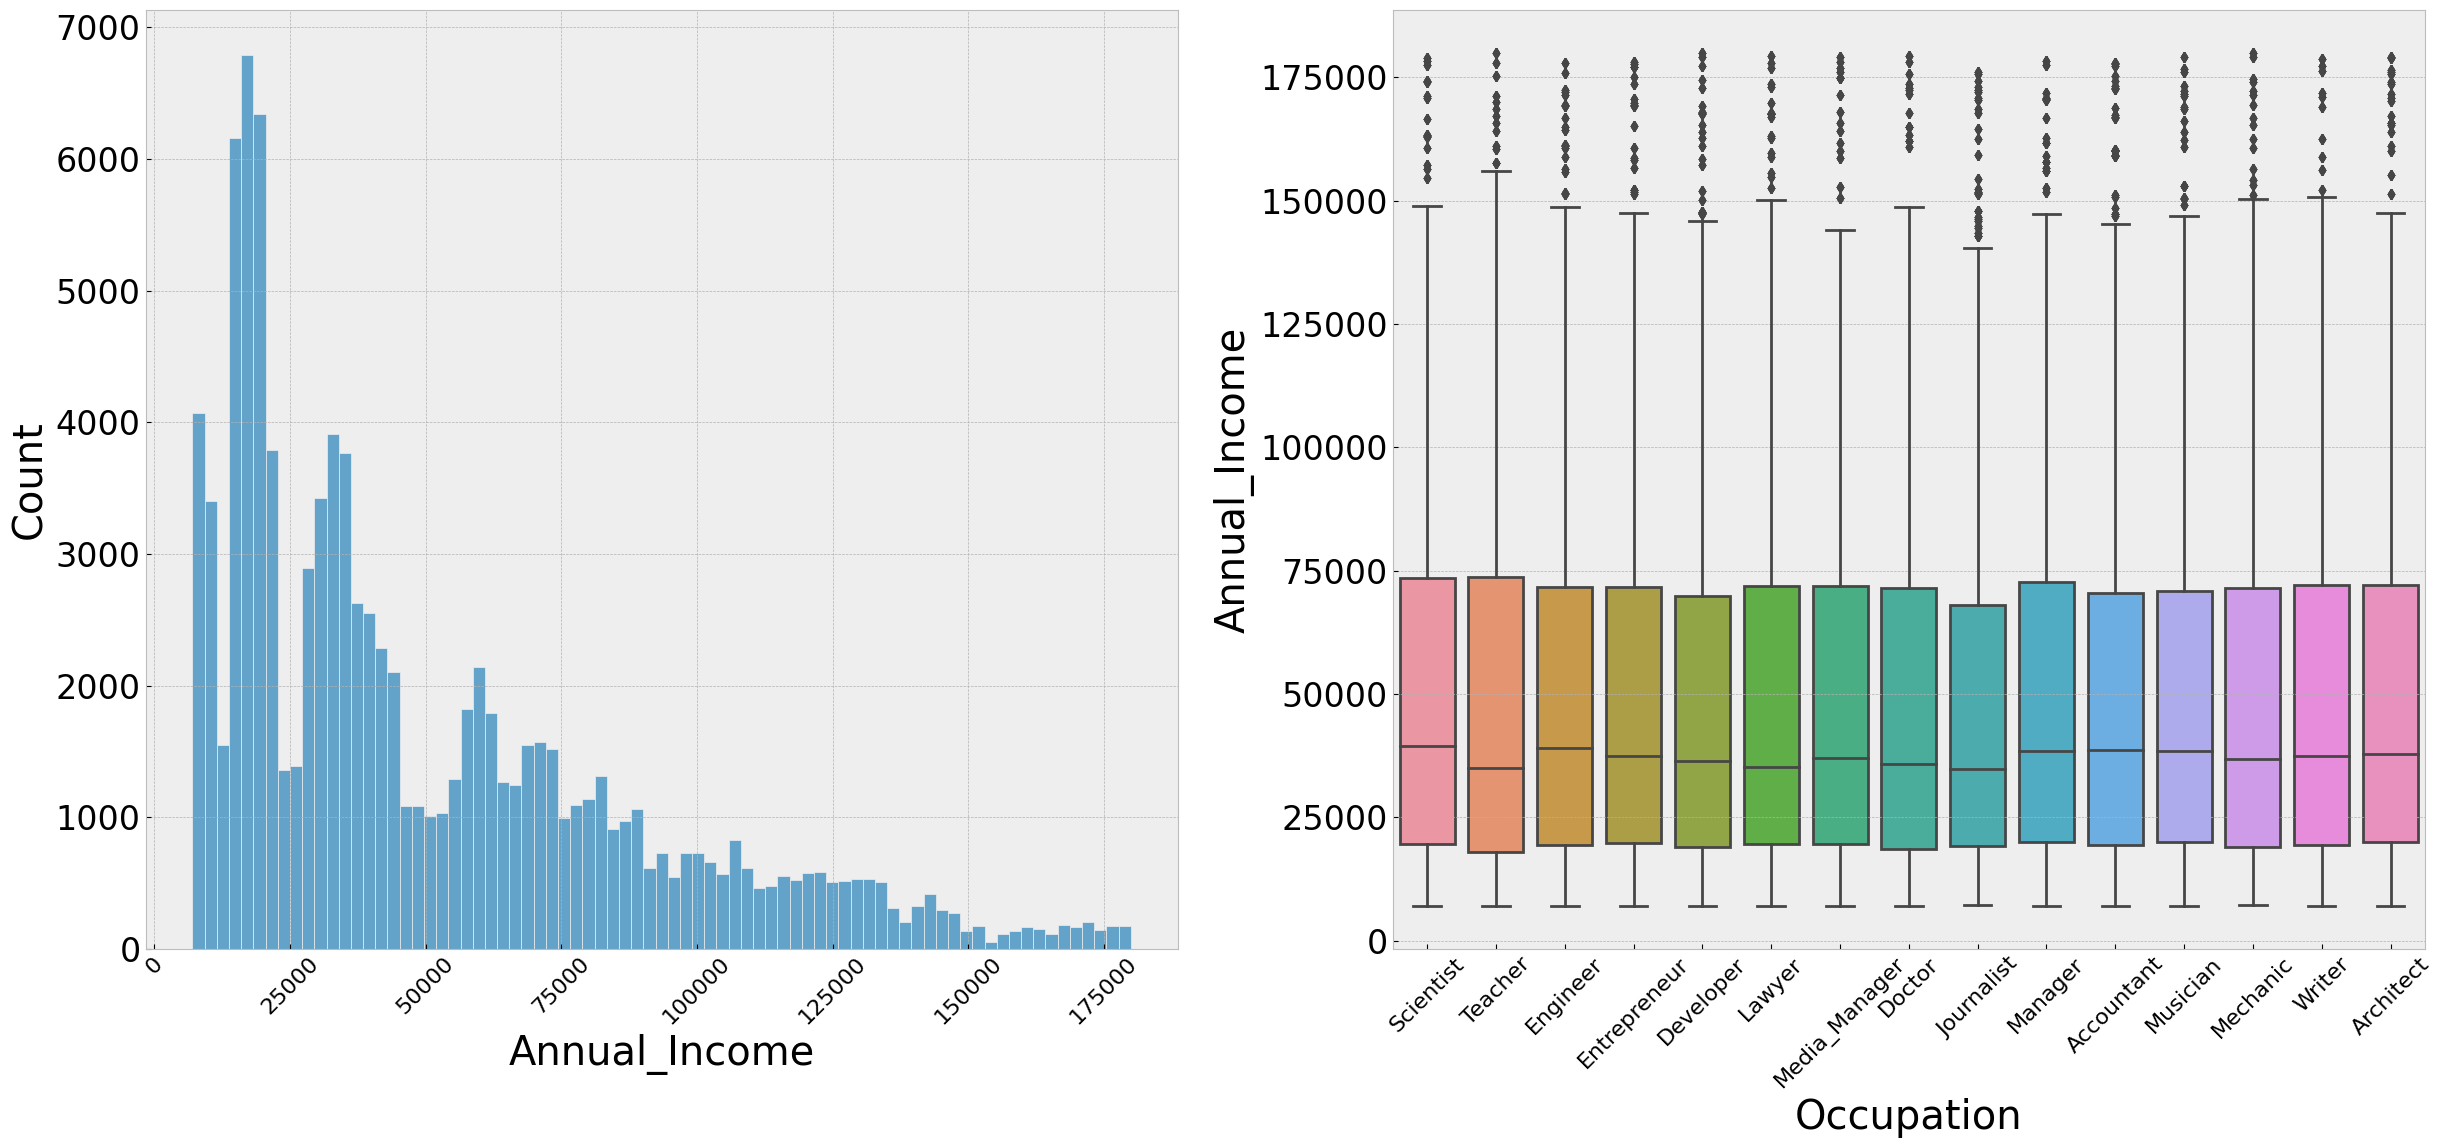

In [63]:
plt.subplot(1,2,1)
sns.histplot(df1['Annual_Income'])
plt.xticks(rotation=45, fontsize=16)


plt.subplot(1,2,2)
sns.boxplot(data = df1 , x='Occupation',y='Annual_Income')
plt.xticks(rotation=45, fontsize=16)
plt.tight_layout()
plt.show()

### Num_of_Loan

In [64]:
df1['Num_of_Loan'] =  df1['Num_of_Loan'].apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Num_of_Loan'] = df1['Num_of_Loan'].astype(np.int64)

In [65]:
df1['Num_of_Loan'].value_counts(dropna=False)

3       15104
2       15032
4       14743
0       10930
1       10606
        ...  
321         1
1439        1
663         1
613         1
966         1
Name: Num_of_Loan, Length: 413, dtype: int64

In [66]:
df1['Num_of_Loan'] = df1.groupby('Customer_ID')['Num_of_Loan'].transform(calcular_moda)

In [67]:
df1['Num_of_Loan'].value_counts(dropna=False)

3    15752
2    15712
4    15456
0    11408
1    11128
6     8144
7     7680
5     7528
9     3856
8     3336
Name: Num_of_Loan, dtype: int64

### Num_of_Delayed_Payment

In [68]:
df1['Num_of_Delayed_Payment'] = df1['Num_of_Delayed_Payment'].astype(str).apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Num_of_Delayed_Payment'] = pd.to_numeric(df1['Num_of_Delayed_Payment'],errors='coerce')

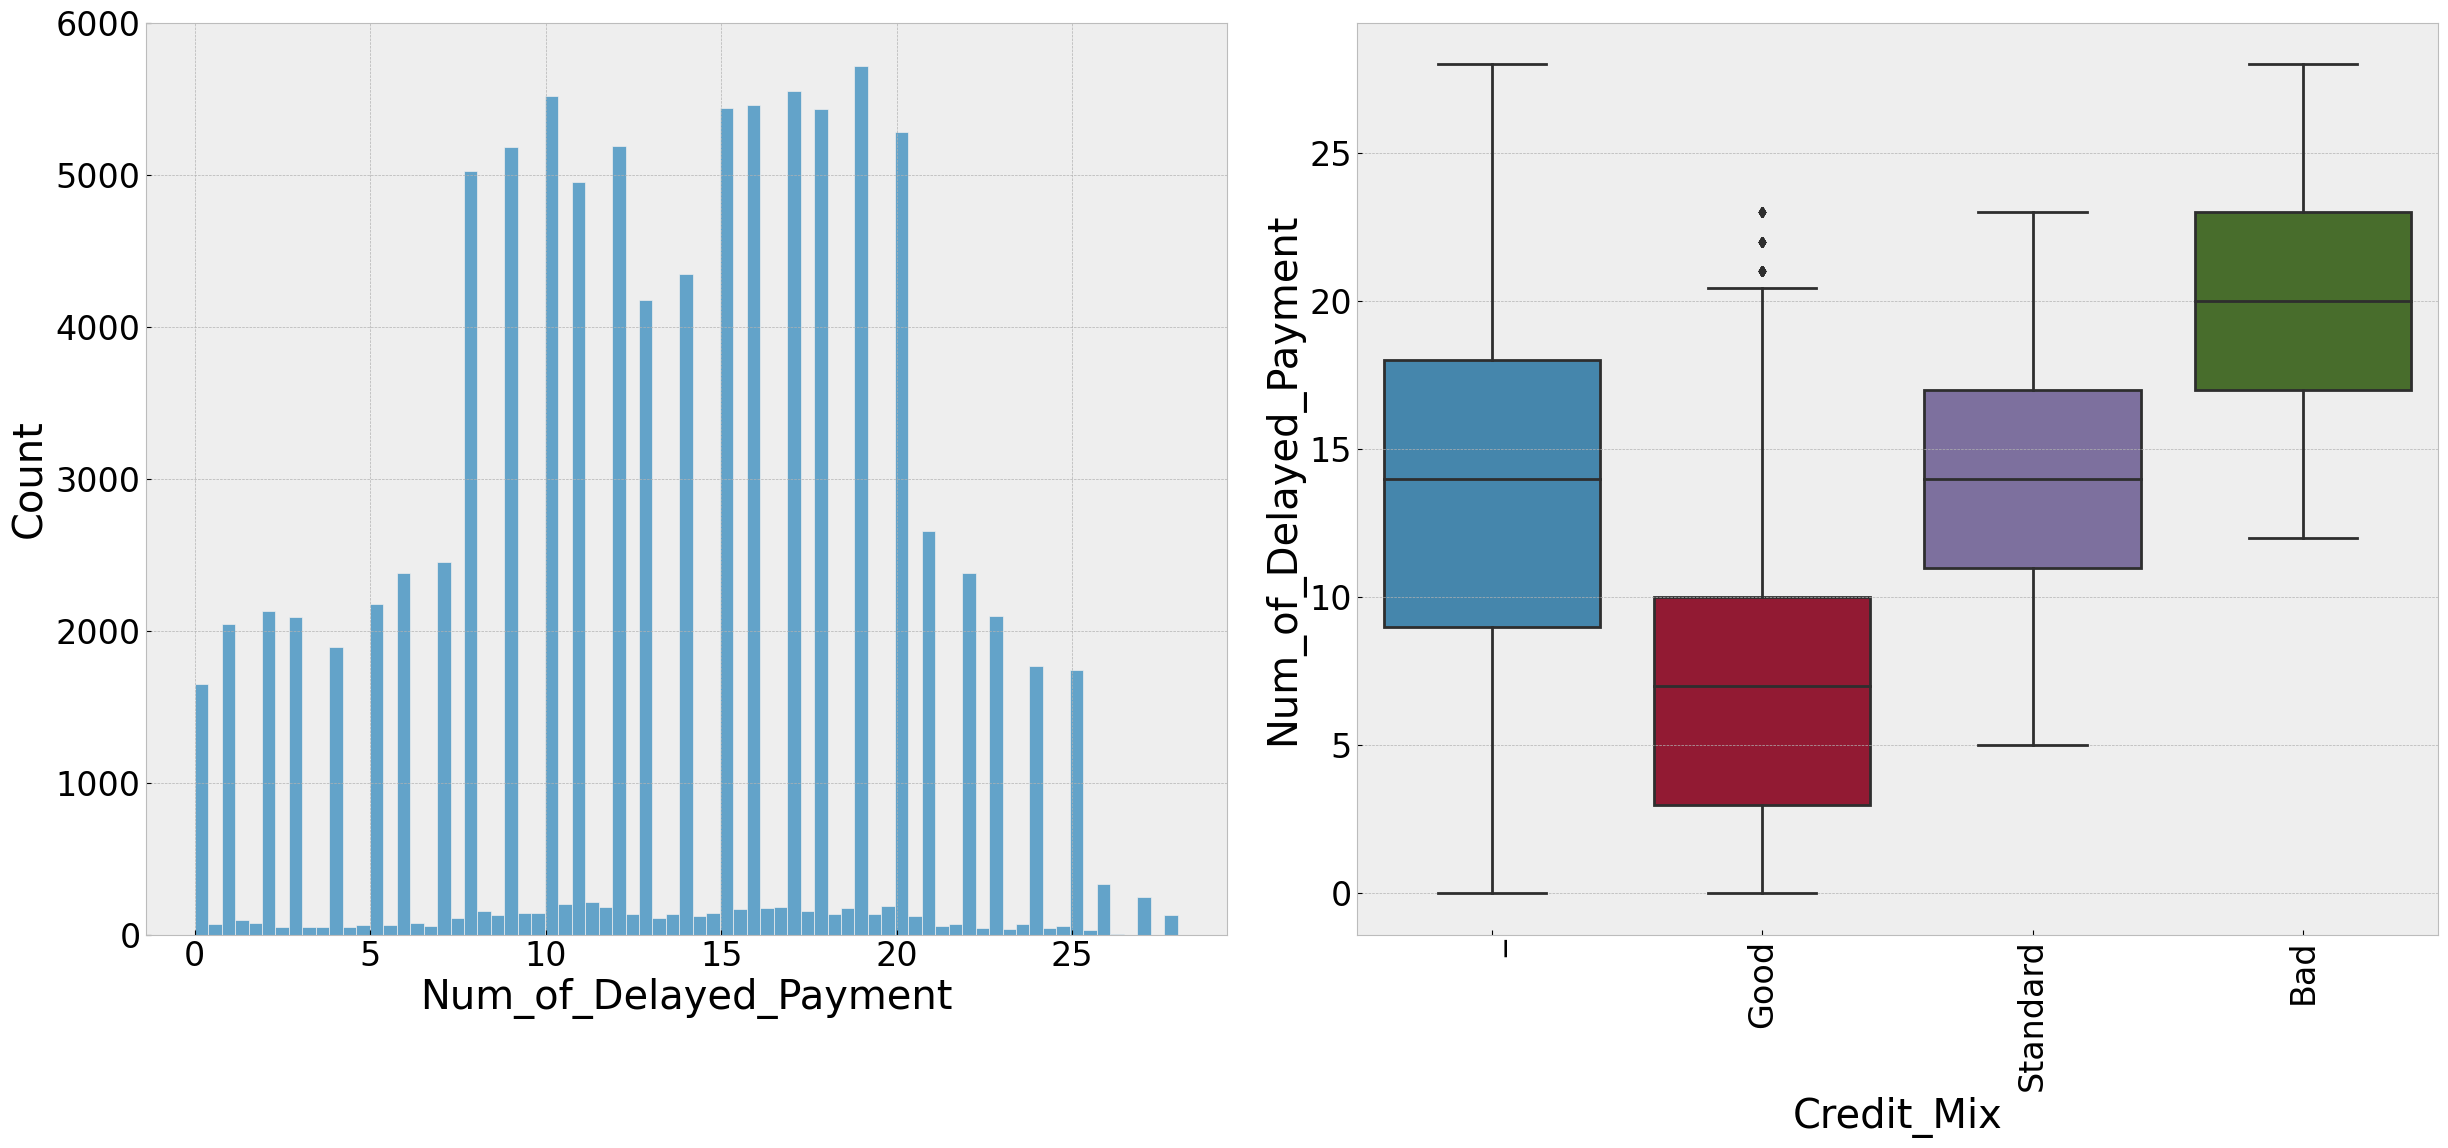

In [73]:
plt.subplot(1,2,1)
sns.histplot(df1['Num_of_Delayed_Payment'])

plt.subplot(1,2,2)
sns.boxplot(df1, x= 'Credit_Mix', y='Num_of_Delayed_Payment')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [69]:
df1['Num_of_Delayed_Payment'].value_counts(dropna=False).to_frame().head(10).reset_index().sort_values('index',ascending=False)

,index,Num_of_Delayed_Payment
7,20.000,5089
1,19.000,5481
6,18.000,5216
2,17.000,5412
3,16.000,5312
5,15.000,5237
8,12.000,5059
4,10.000,5309
9,9.000,4981
0,NaN,7002


In [70]:
## Maximum average delay number is 28, so we will replace values above this with 'NaN' and update them with the customer's average
df1.loc[df1['Num_of_Delayed_Payment'] > 28, 'Num_of_Delayed_Payment'] = np.nan
df1.loc[df1['Num_of_Delayed_Payment'].isna(),'Num_of_Delayed_Payment'] = df1.groupby('Customer_ID')["Num_of_Delayed_Payment"].transform(mean)

In [71]:
df1.groupby('Customer_ID')["Num_of_Delayed_Payment"].mean()

Customer_ID
CUS_0x1000   25.000
CUS_0x1009   17.857
CUS_0x100b    7.375
CUS_0x1011   14.500
CUS_0x1013    8.429
              ...  
CUS_0xff3     8.625
CUS_0xff4    12.125
CUS_0xff6     4.000
CUS_0xffc    16.250
CUS_0xffd    11.429
Name: Num_of_Delayed_Payment, Length: 12500, dtype: float64

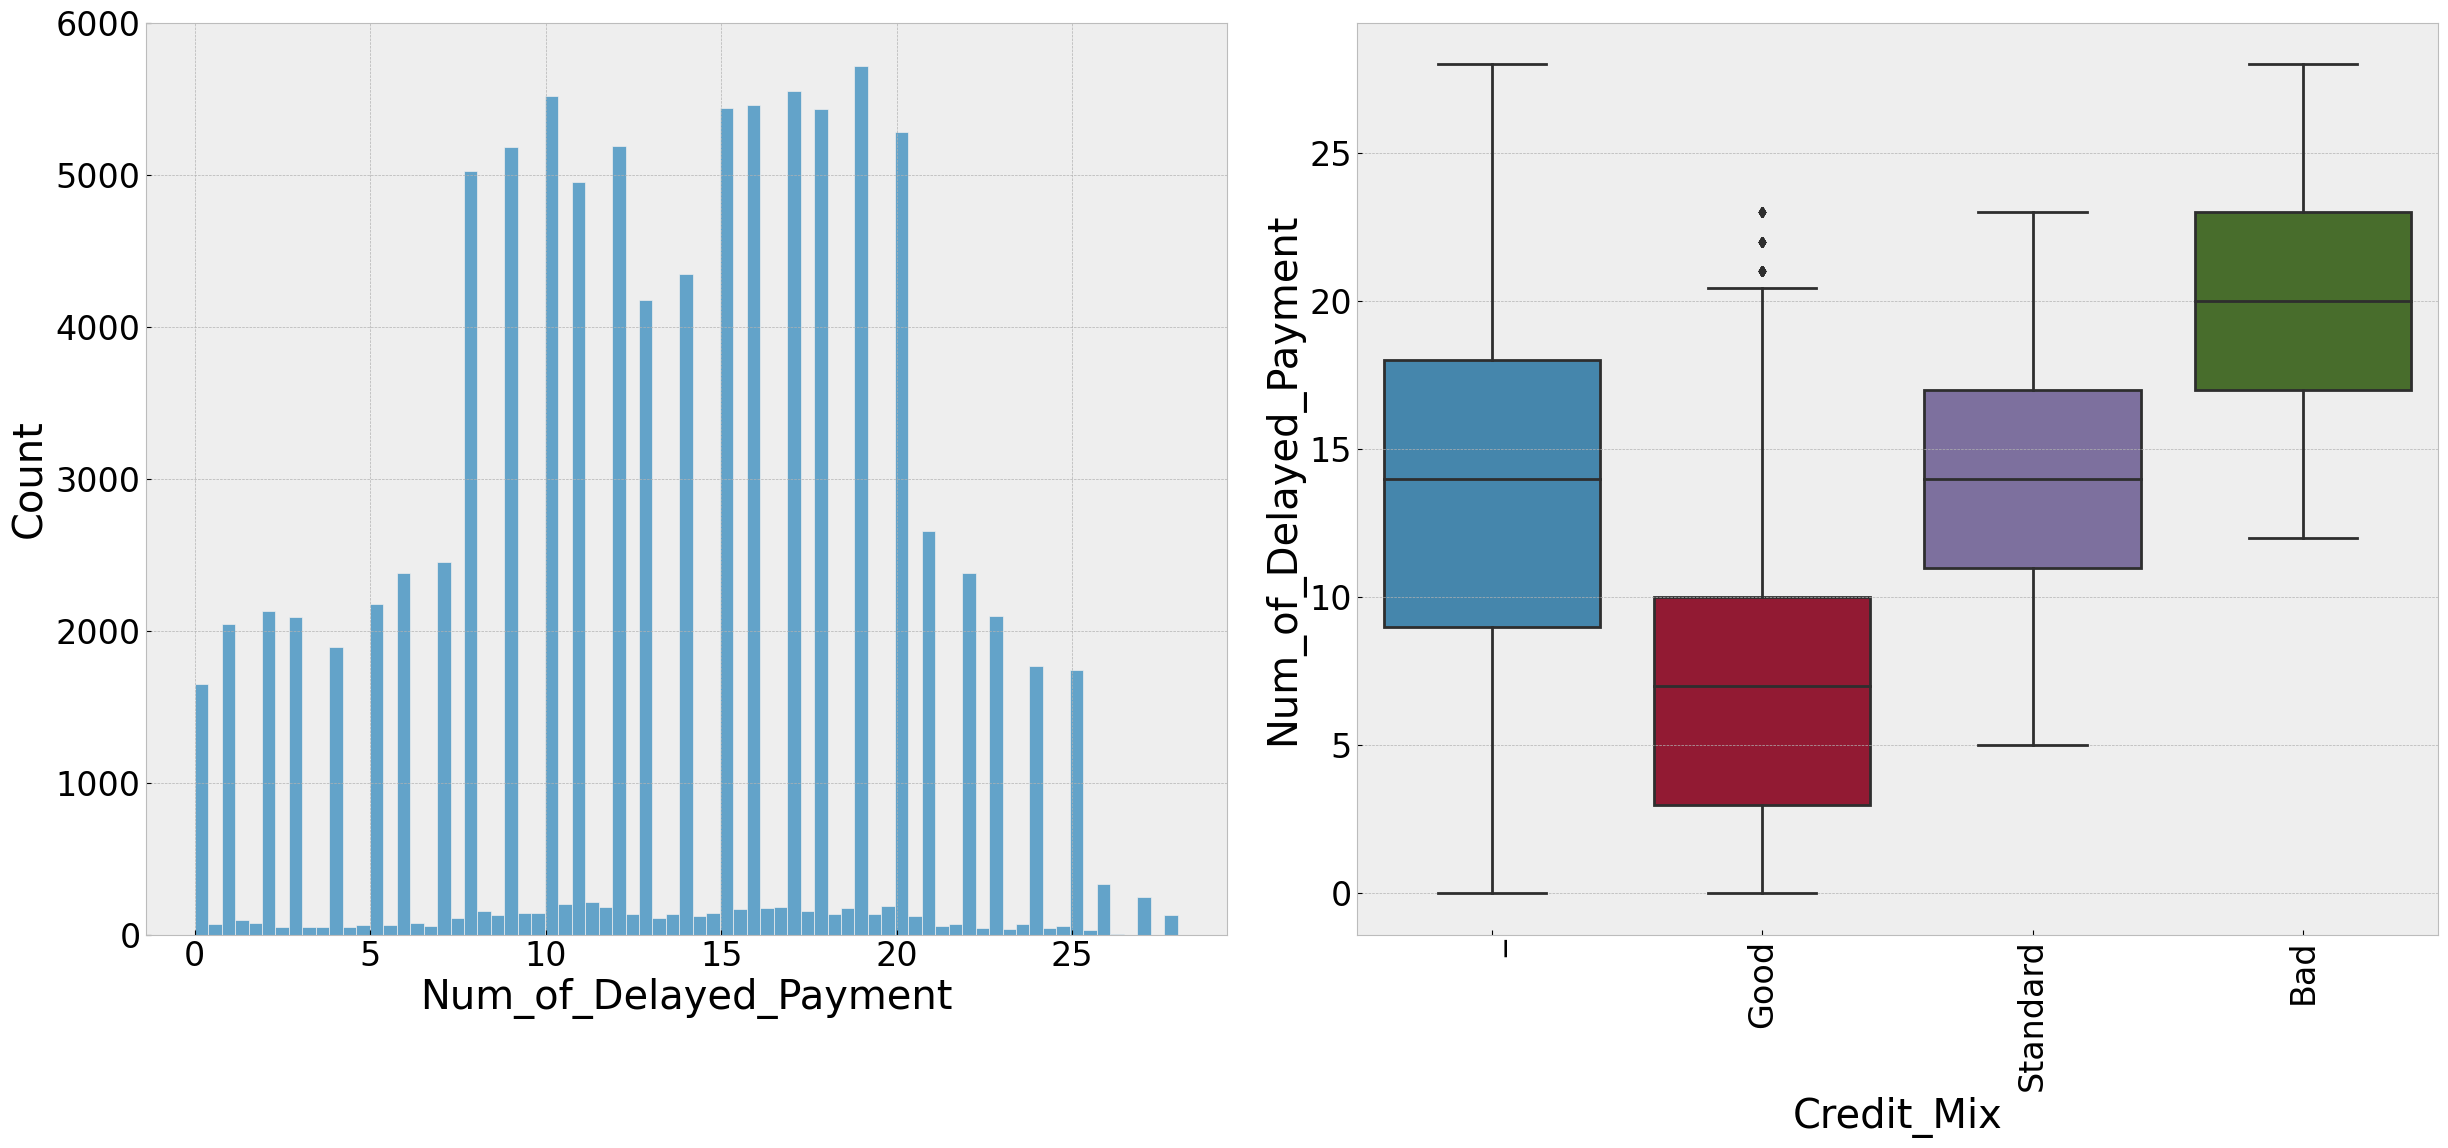

In [72]:
plt.subplot(1,2,1)
sns.histplot(df1['Num_of_Delayed_Payment'])

plt.subplot(1,2,2)
sns.boxplot(df1, x= 'Credit_Mix', y='Num_of_Delayed_Payment')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Changed_Credit_Limit

In [74]:
df1['Changed_Credit_Limit'] = df1['Changed_Credit_Limit'].astype(str).apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Changed_Credit_Limit'] = pd.to_numeric(df1['Changed_Credit_Limit'],errors='coerce')
df1['Changed_Credit_Limit'] = df1['Changed_Credit_Limit'].astype(float)

In [75]:
df1['Changed_Credit_Limit'].value_counts(dropna=False).to_frame().head(10).reset_index().sort_values('index',ascending=False)

,index,Changed_Credit_Limit
2,11.500,127
7,11.490,113
3,11.320,126
4,10.060,121
6,8.230,115
1,8.220,133
5,7.350,121
9,7.330,110
8,3.930,111
0,NaN,2091


<Axes: xlabel='Changed_Credit_Limit', ylabel='Count'>

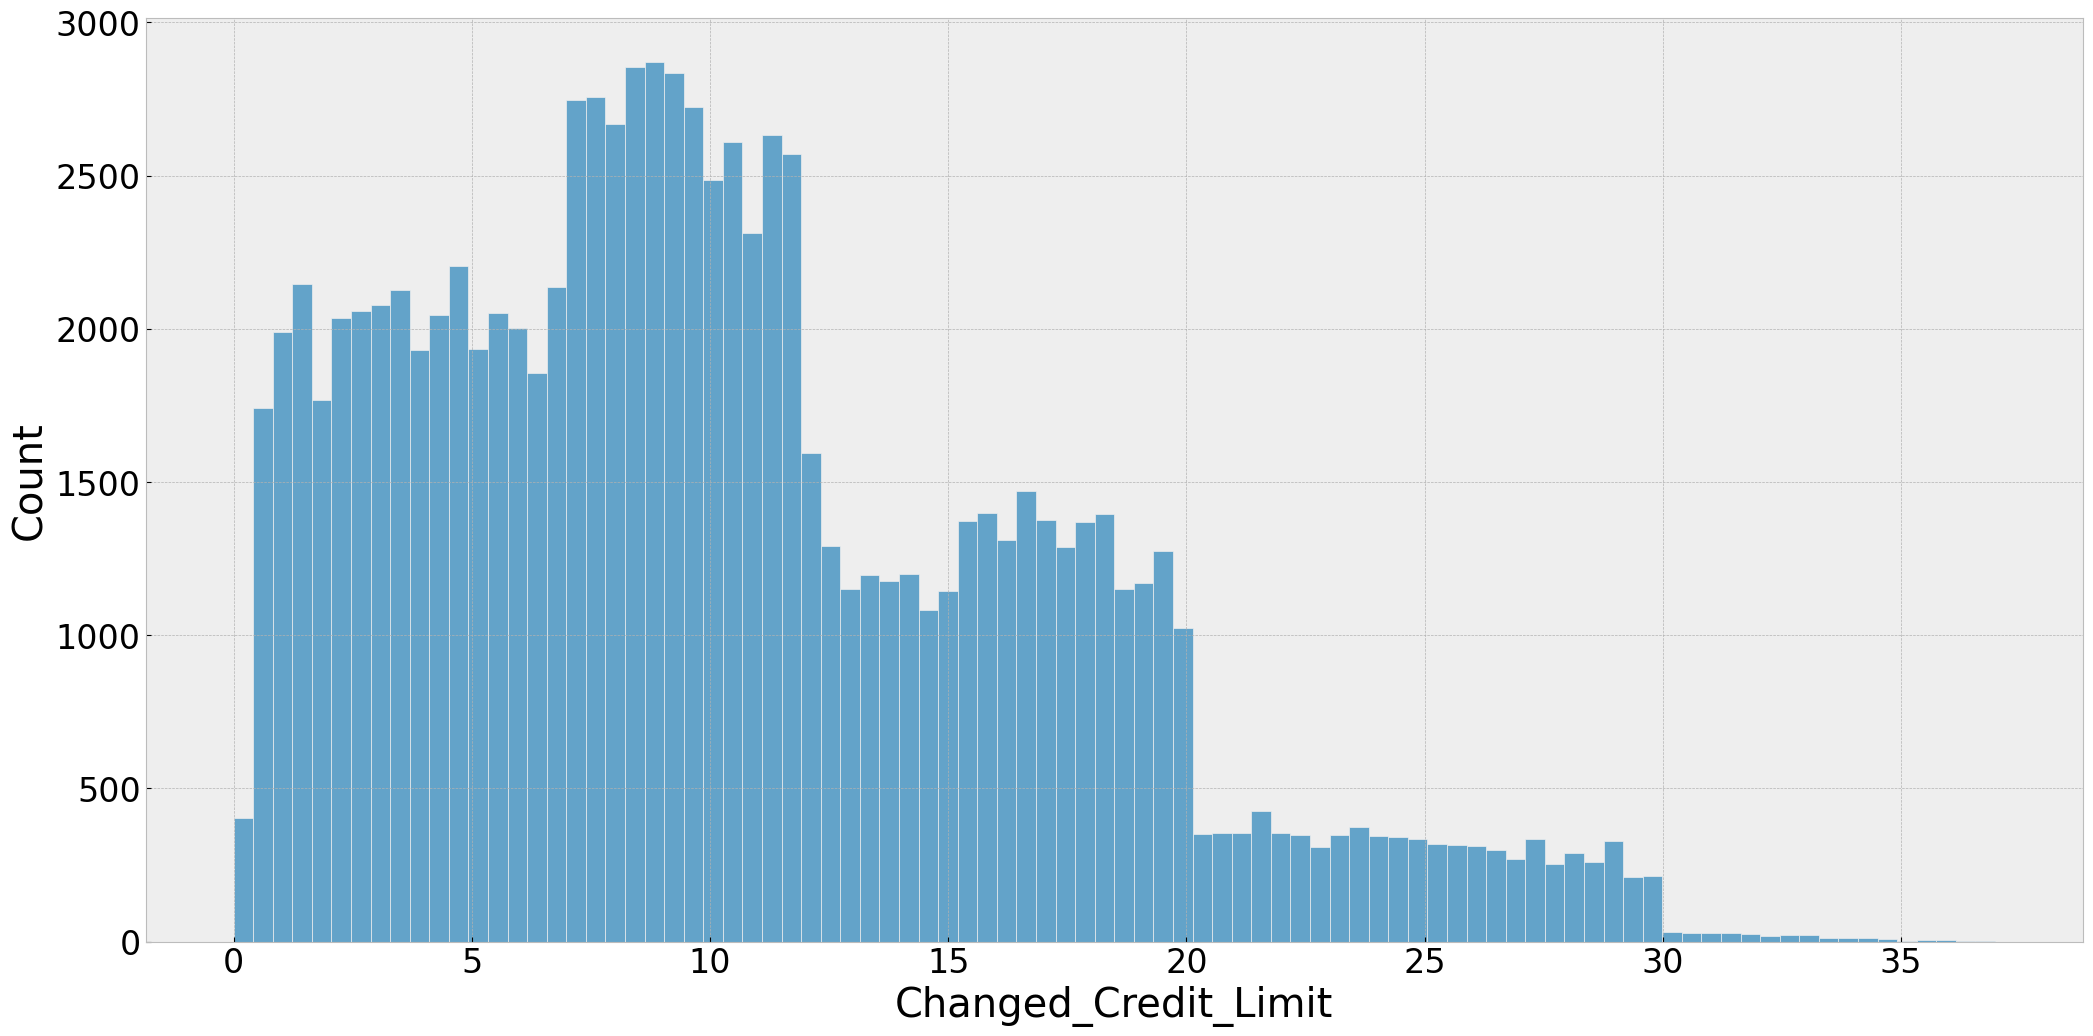

In [76]:
sns.histplot(df1['Changed_Credit_Limit'])

In [77]:
df1.loc[df1['Changed_Credit_Limit'].isna(),'Changed_Credit_Limit'] = df1.groupby('Customer_ID')["Changed_Credit_Limit"].transform(mean)

### Outstanding_Debt

In [46]:
df1['Outstanding_Debt'] = df1['Outstanding_Debt'].astype(str).apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Outstanding_Debt'] = pd.to_numeric(df1['Outstanding_Debt'],errors='coerce')
df1['Outstanding_Debt'] = df1['Outstanding_Debt'].astype(float)

In [ ]:
df1['Outstanding_Debt']

In [ ]:
df1['Outstanding_Debt'].describe()

### Num_Credit_Inquiries

In [80]:
df1['Num_Credit_Inquiries'] = df1['Num_Credit_Inquiries'].astype(str).apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Num_Credit_Inquiries'] = pd.to_numeric(df1['Num_Credit_Inquiries'],errors='coerce')

In [81]:
df1['Num_Credit_Inquiries']

0       4.000
1       4.000
2       4.000
3       4.000
4       4.000
         ... 
99995   3.000
99996   3.000
99997   3.000
99998   3.000
99999   3.000
Name: Num_Credit_Inquiries, Length: 100000, dtype: float64

### Amount_invested_monthly

In [48]:
df1['Amount_invested_monthly'] = df1['Amount_invested_monthly'].astype(str).apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Amount_invested_monthly'] = pd.to_numeric(df1['Amount_invested_monthly'],errors='coerce')
df1['Amount_invested_monthly'] = df1['Amount_invested_monthly'].astype(float)

In [ ]:
df1['Amount_invested_monthly'].plot(kind='hist')

In [ ]:
df1['Amount_invested_monthly'].describe()

In [ ]:
df1[df1['Amount_invested_monthly']>1000]['Amount_invested_monthly'].plot(kind='hist')

In [ ]:
df1[(df1['Amount_invested_monthly']>1000)&(df1['Amount_invested_monthly']<10000)]['Amount_invested_monthly'].plot(kind='hist')

In [ ]:
df1['Amount_invested_monthly'].value_counts().reset_index().sort_values('index',ascending=False)

In [ ]:
df1.loc[df1['Amount_invested_monthly']==10000,'Amount_invested_monthly'] = np.nan

df1.loc[df1['Amount_invested_monthly'].isna(),'Amount_invested_monthly'] = df1.groupby('Customer_ID')['Amount_invested_monthly'].transform(mean)

In [ ]:
df1['Amount_invested_monthly'].plot(kind='hist')

### Monthly_Balance

In [49]:
df1['Monthly_Balance'] = df1['Monthly_Balance'].astype(str).apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Monthly_Balance'] = pd.to_numeric(df1['Monthly_Balance'],errors='coerce')
df1['Monthly_Balance'] = df1['Monthly_Balance'].astype(float)

In [ ]:
df1['Monthly_Balance'].describe()

In [ ]:
plt.subplot(1,2,1)
sns.boxplot(df1['Monthly_Balance'])

plt.subplot(1,2,2)
hist(df1['Monthly_Balance'])
plt.tight_layout()

In [ ]:
df1['Monthly_Balance'].value_counts(dropna=False).to_frame().sort_index(ascending=False)

In [ ]:
df1.loc[df1['Monthly_Balance']>2000,'Monthly_Balance'] = np.nan
df1.loc[df1['Monthly_Balance'].isna(),'Monthly_Balance'] = df1.groupby('Customer_ID')['Monthly_Balance'].transform(mean)

In [ ]:
df1['Monthly_Balance'].describe()

In [ ]:
plt.subplot(1,2,1)
sns.boxplot(df1['Monthly_Balance'])

plt.subplot(1,2,2)
sns.histplot(df1['Monthly_Balance'])
plt.tight_layout()